In [ ]:
!pip install transformers[torch] datasets evaluate -q
!pip install ydata-profiling[notebook] -q
!pip install nltk  contractions inflect emoji -q
# !pip install unicodedata

^C
ERROR: Operation cancelled by user



KeyboardInterrupt



In [ ]:
# !unzip /kaggle/input/quora-insincere-questions-classification/embeddings.zip

In [ ]:
import torch
import transformers

import numpy as np
import pandas as pd
import re
import sys
import os
import random
import string


from ydata_profiling import ProfileReport
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import emoji
import nltk
import spacy
import inflect
import unicodedata
import contractions


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score,
    confusion_matrix
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 10)
%matplotlib inline

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
class Config:
    DATA_PATH = "/kaggle/input/quora-insincere-questions-classification"
    TRAIN_PATH = f"{DATA_PATH}/train.csv"
    TEST_PATH = f"{DATA_PATH}/test.csv"
    SUBMIT = f"{DATA_PATH}/sample_submission.csv"
    EMBEDDINGS_WIKI_NEWS = f"/kaggle/working/wiki-news-300d-1M/wiki-news-300d-1M.vec"
    EMBEDDINGS_GOOGLE_NEWS = "/kaggle/working/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
    EMBEDDINGS_GLOVE = "/kaggle/working/glove.840B.300d/glove.840B.300d.txt"
    EMBEDDINGS_PARAGRAM = "/kaggle/working/paragram_300_sl999/paragram_300_sl999.txt"
    RANDOM_STATE = 42
    SEED = 42
    VALID_SIZE = 0.2
    DEVICE = torch.device("0" if torch.cuda.is_available() else "cpu")


In [ ]:
config = Config()

In [ ]:
def set_all_seeds(seed=42) -> None:

    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
set_all_seeds(config.SEED)

In [ ]:
train_df = pd.read_csv(config.TRAIN_PATH)
test_df = pd.read_csv(config.TEST_PATH)
print('Train shape: ',train_df.shape, '\n', 'Test shape', test_df.shape)

Train shape:  (1306122, 3) 
 Test shape (375806, 2)


In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
# profile_train = ProfileReport(train_df, title="Pandas Profiling Report Train DataFrame")
# profile_train.to_file("train_report.html")

In [ ]:
# profile_test = ProfileReport(test_df, title="Pandas Profiling Report Test DataFrame")
# profile_test.to_file("test_report.html")

In [ ]:
class_dict = {0: 'negative', 1: 'positive'}
counts = train_df['target'].value_counts()
counts.plot(kind='bar')

In [ ]:
def clean_text(text):
    # HTML-теги: первый шаг - удалить из входного текста все HTML-теги
    clean_text = re.sub('<[^<]+?>','', text)

    # URL и ссылки: далее - удаляем из текста все URL и ссылки
    clean_text = re.sub(r'http\S+', '', clean_text)

    # Эмоджи и эмотиконы: используем собственную функцию для преобразования эмоджи в текст
    # Важно понимать эмоциональную окраску обрабатываемого текста

#     clean_text = emojis_words(clean_text)

    clean_text = clean_text.lower()

    # Убираем все пробелы
    # Так как все данные теперь представлены словами - удалим пробелы
    clean_text = re.sub('\s+', ' ', clean_text)

   # Преобразование символов с диакритическими знаками к ASCII-символам: используем функцию normalize из модуля unicodedata и преобразуем символы с диакритическими знаками к ASCII-символам
    clean_text = unicodedata.normalize('NFKD', clean_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Разворачиваем сокращения: текст часто содержит конструкции вроде "don't" или "won't", поэтому развернём подобные сокращения
    clean_text = contractions.fix(clean_text)

    # Убираем специальные символы: избавляемся от всего, что не является "словами"
    clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text)

    # Записываем числа прописью: 100 превращается в "сто" (для компьютера)
#     temp = inflect.engine()
#     words = []
#     for word in clean_text.split():
#         if word.isdigit():
#             words.append(temp.number_to_words(word))
#         else:
#             words.append(word)
#     clean_text = ' '.join(words)

    # Стоп-слова: удаление стоп-слов - это стандартная практика очистки текстов

    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(clean_text)
    tokens = [token for token in tokens if token not in stop_words]
    clean_text = ' '.join(tokens)

    # Знаки препинания: далее - удаляем из текста все знаки препинания
    clean_text = re.sub(r'[^\w\s]', '', clean_text)

    return clean_text

# Функция для преобразования эмоджи в слова
def emojis_words(text):

    # Модуль emoji: преобразование эмоджи в их словесные описания
    clean_text = emoji.demojize(text, delimiters=(" ", " "))

    # Редактирование текста путём замены ":" и" _", а так же - путём добавления пробела между отдельными словами
    clean_text = clean_text.replace(":", "").replace("_", " ")
    clean_text = clean_text.replace(":", "").replace("_", " ")
    return clean_text

def lemmatization(text):
    lemma = WordNetLemmatizer()
    return [lemma.lemmatize(word=w, pos='v') for w in text]

def stemming(text):
    stemmer = SnowballStemmer("english")
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [ ]:
train_df['question_text'] = train_df['question_text'].apply(clean_text)
test_df['question_text'] = test_df['question_text'].apply(clean_text)

In [ ]:
# train_df.to_csv('Clean_train_df.csv', index=False)
# test_df.to_csv('Clean_test_df.csv', index=False)

In [ ]:
train_df['question_text'] = train_df['question_text'].apply(stemming)
test_df['question_text'] = test_df['question_text'].apply(stemming)

In [ ]:
# train_df.to_csv('Preprocessing_train_df.csv', index=False)
# test_df.to_csv('Preprocessing_test_df.csv', index=False)

In [ ]:
X = train_df['question_text']
y = train_df['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=config.RANDOM_STATE, test_size=config.VALID_SIZE, shuffle=True)

# TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)
X_train = tfidf_vectorizer.transform(X_train)
X_valid = tfidf_vectorizer.transform(X_valid)

# **Logistic Regression**

In [ ]:
log_reg = LogisticRegression(random_state=config.RANDOM_STATE)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_valid)
f1_score = f1_score(y_valid, y_pred)
print(f'F1 score: {f1_score}')
print(classification_report(y_valid, y_pred))

F1 score: 0.481073388900183
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    245369
           1       0.68      0.37      0.48     15856

    accuracy                           0.95    261225
   macro avg       0.82      0.68      0.73    261225
weighted avg       0.94      0.95      0.94    261225



[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

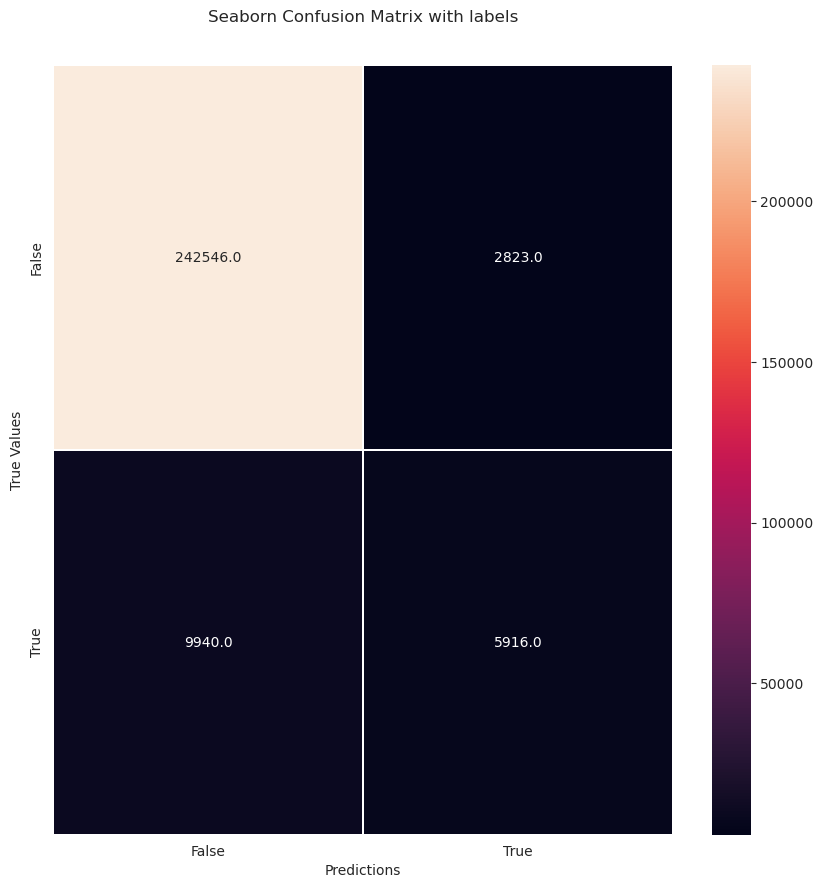

In [ ]:
confution_matr = confusion_matrix(y_valid, y_pred)
ax = sns.heatmap(confution_matr, linewidths=0.01, annot=True,fmt= '.1f', color='red' )
ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('Predictions')
ax.set_ylabel('True Values')

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

# **Logistic RegressionCV**

In [ ]:
log_reg_cv = LogisticRegressionCV(random_state=config.RANDOM_STATE)
log_reg_cv.fit(X_train, y_train)

y_pred_cv = log_reg_cv.predict(X_valid)
f1_score = f1_score(y_valid, y_pred)
print(f'F1 score: {f1_score}')
print(classification_report(y_valid, y_pred))

F1 score: 0.481073388900183
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    245369
           1       0.68      0.37      0.48     15856

    accuracy                           0.95    261225
   macro avg       0.82      0.68      0.73    261225
weighted avg       0.94      0.95      0.94    261225



<Axes: >

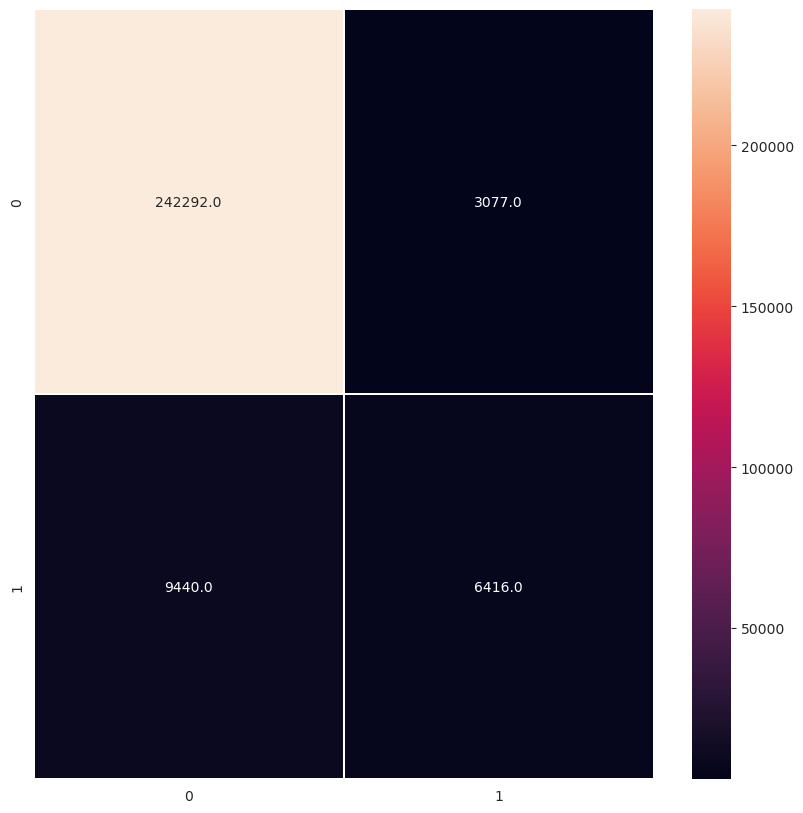

In [ ]:
confution_matr = confusion_matrix(y_valid, y_pred_cv)
sns.heatmap(confution_matr, linewidths=0.01, annot=True,fmt= '.1f', color='red' )

# Prediction

In [ ]:
X_test = tfidf_vectorizer.transform(test_df['question_text'])

In [ ]:
submit_df = pd.read_csv(config.SUBMIT)
submit_df['prediction'] = log_reg_cv.predict(X_test)
submit_df.to_csv('submit.csv', index=False)